In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#books = pd.read_csv('BX-Books.csv',dtype={'ISBN': 'int', 'bookTitle': 'str', 'bookAuthor': 'str', 'yearOfPublication': 'int', 'publisher': 'str','imageUrlS': 'str','imageUrlM': 'str','imageUrlL': 'str'}, sep=';', error_bad_lines=False, encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding='latin-1',dtype={'yearOfPublication': 'float32'})
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1')
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\konst\AppData\Local\Temp\ipykernel_18212\425355100.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding='latin-1',dtype={'yearOfPublication': 'float32'})
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8

# Q1: Understanding the data - Data description

Obtain the Book Crossing data set1
this dataset contains information about books, users, and about user
ratings of the book.
Briefly describe the data set, including information about its size. Display in reverse order the book
popularity, the author popularity, and the age ranges by reading activity. 


In [3]:
user_count = ratings['userID'].value_counts()
book_count = ratings['bookRating'].value_counts()



In [4]:
combined_book_rating = pd.merge(ratings, books, on='ISBN')
combined_book_rating = combined_book_rating.drop({'yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL'}, axis='columns')
combined_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


Text(0.5, 1.0, 'Top Books by Most Ratings')

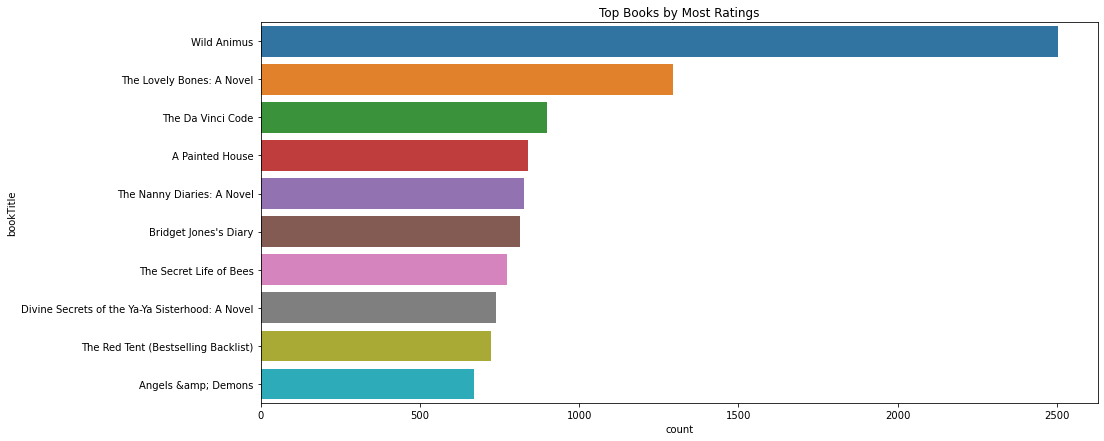

In [5]:
plt.figure(figsize=(15,7))
sns.countplot(y='bookTitle',data=combined_book_rating, order=combined_book_rating['bookTitle'].value_counts().index[:10])
plt.title('Top Books by Most Ratings')

Text(0.5, 1.0, 'No of books by an author (Top 10)')

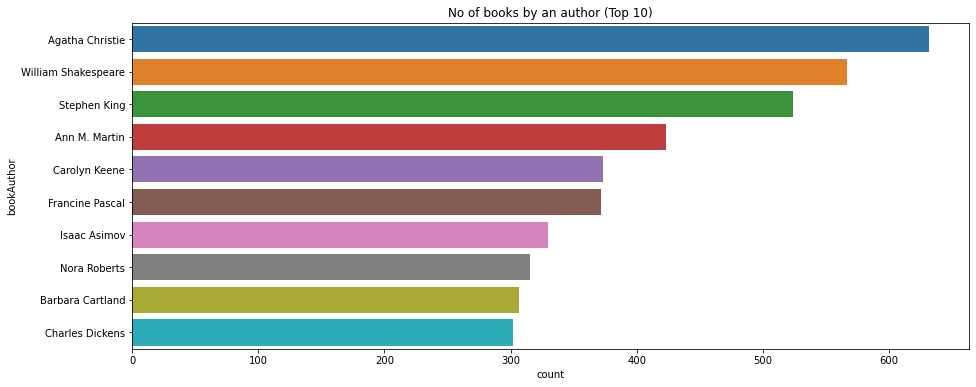

In [6]:
plt.figure(figsize=(15,6))
sns.countplot(y="bookAuthor", data=books,order=books['bookAuthor'].value_counts().index[:10])
plt.title("No of books by an author (Top 10)")

Authors with the most books was Agatha Christie, William Shakespeare and Stephen King.



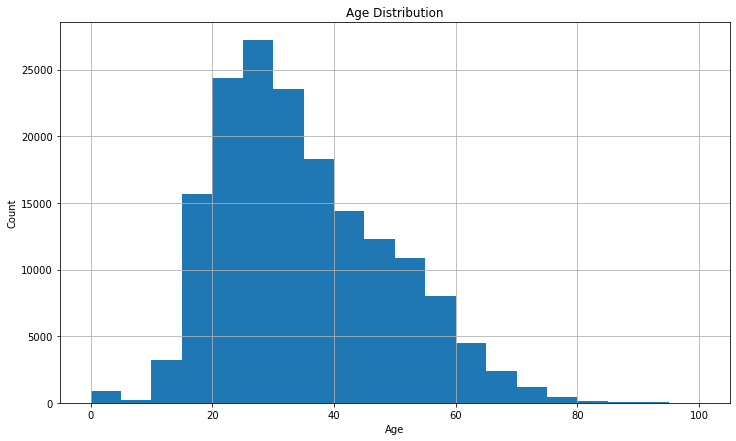

In [7]:
users.Age.hist(bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], figsize=(12,7))
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()



The Majority of the readers were of the age bracket 20-35 


# Q1: Understanding the data - Outlier detection I

In a data set the elements that exhibit a strange behavior are considered as outliers. This must be
quantified. One way is to use the z-score2
, and call outlier whatever is higher than a threshold (e.g. 3).
Detect the outliers among the books, authors, and users, in terms of how many times they have been
read (for books and authors) or how many books they have read for users. 

We will consider the outliers in terms of Age and see if we need to remove some.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

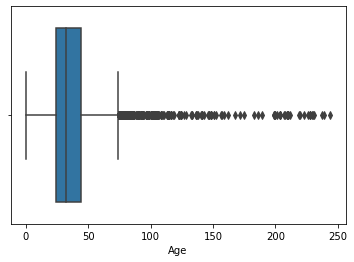

In [8]:
# For location is not numeric, so we don't expect any outlier 

sns.boxplot(users['Age'])

# Here in age we can spot age values greater than 100 which are outliers, 
# and unrealistic because people older than 100 years old is very rare to be alive (we will come back here)

# Data Cleaning

We will reduce the dataset for getting more accurate data.We will include the users who have a lot of ratings for books because we believe so that they will be more precise and experianced on how to rate a book correctly.Therefore we will Exclude users with less than 150 ratings and books with less than 100 ratings


In [9]:
ratings = ratings[ratings['userID'].isin(user_count[user_count >= 150].index)] 
ratings = ratings[ratings['bookRating'].isin(book_count[book_count >= 100].index)]

In [10]:
book_rating_count = combined_book_rating.groupby('bookTitle')['bookRating'].count().reset_index()
book_rating_count.head()

,bookTitle,bookRating
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [11]:
book_rating_count = book_rating_count.rename(columns = {
    'bookRating' : 'totalRatingCount'
})

book_rating_count.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [12]:
combined_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [13]:
rating_with_totalRatingCount = pd.merge(combined_book_rating, book_rating_count, left_on = 'bookTitle', right_on = 'bookTitle', how= 'left')
rating_with_totalRatingCount.head()
rating_with_totalRatingCount.to_csv ('test.csv')

In [14]:
threshold = 100
popular_books  = rating_with_totalRatingCount.query('totalRatingCount >= @threshold')
popular_books.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
62,276727,0446520802,0,The Notebook,650
63,278418,0446520802,0,The Notebook,650
64,638,0446520802,0,The Notebook,650
65,3363,0446520802,0,The Notebook,650
66,7158,0446520802,10,The Notebook,650


# We will split the locations so we can find the Countries the select the top one, for limitation issues while being an appropriate use at the same because of it's high user base, which possibly means more accuracy

In [15]:
user_location_expanded = users.Location.str.split(',', 2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
#users = users.join(user_location_expanded)

user_location_expanded.head()

,city,state,country
0,nyc,new york,usa
1,stockton,california,usa
2,moscow,yukon territory,russia
3,porto,v.n.gaia,portugal
4,farnborough,hants,united kingdom


In [16]:
top_countries = user_location_expanded.country.value_counts()[:10]
print(f'The top 10 countries with the most users are:\n{top_countries}')

The top 10 countries with the most users are:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


# We will filter the Users to the ones in Usa and only between 12 and 85 years old and drop duplicate values

We believe that ratings are more accurate from people between 12 and 85 years old.Since Usa is the top country in users with a huge difference from Canada we will calculate base on this dataset for accuracy and computational resources

In [17]:
combined = pd.merge(popular_books, users, left_on  = 'userID', right_on = 'userID', how = 'left')
combined.head()
combined.shape

(183799, 7)

In [18]:
usa_ratings = combined[combined['Location'].str.contains('usa')]
usa_ratings = combined[combined['Age'].between(12, 85)]
#us_canada_ratings = us_canada_ratings.drop('Age', axis='columns')
usa_ratings = usa_ratings.drop_duplicates(['userID', 'bookTitle'])
usa_ratings.shape


(127421, 7)

# Q2: Recommender System: Find similarities-10%

1. You will need to find the similarity between all of pairs users based on the books they have read.
a. Store the results in a csv file, entitled: ‘user-pairs-books.data’

# Let's Prepare the Matrix for Cosine Similarity

In [19]:

# We will first create our pivot table
usa_ratings_pivot = usa_ratings.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)

In [20]:
usa_ratings_pivot.head() 
pd.DataFrame(usa_ratings_pivot).to_csv("Pivotnew.csv ")

In [21]:
cs = cosine_similarity(usa_ratings_pivot)
print (cs)
pd.DataFrame(cs).to_csv("‘user-pairs-books.data ")
pd.DataFrame(cs).to_csv("‘user-pairs-books.csv")

[[1.         0.02159723 0.         ... 0.04029814 0.01770722 0.01079566]
 [0.02159723 1.         0.01682558 ... 0.01012915 0.02011646 0.04173341]
 [0.         0.01682558 1.         ... 0.         0.         0.        ]
 ...
 [0.04029814 0.01012915 0.         ... 1.         0.         0.        ]
 [0.01770722 0.02011646 0.         ... 0.         1.         0.        ]
 [0.01079566 0.04173341 0.         ... 0.         0.         1.        ]]


# Q2: Recommender System: Recommend-10%

Compute the recommendation according to the collaborative filtering. The core idea is the neighbors
vote according to their similarity to the user.

# We will see how much precise a user-user recommendation is with a few neighbors

For this approach we will pick a random user and recommend the most related users to him

In [22]:
usa_ratings_user_pivot = usa_ratings.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)



In [23]:
from scipy.sparse import csr_matrix

usa_ratings_matrix = csr_matrix(usa_ratings_user_pivot.values)

In [24]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(usa_ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [25]:
query_index = np.random.choice(usa_ratings_matrix.shape[0])
print(query_index)
distance, indices = model.kneighbors(usa_ratings_user_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

13775


In [26]:
 usa_ratings_user_pivot.index[query_index]

169192

In [27]:
for i in range(0, len(distance.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(usa_ratings_user_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, usa_ratings_user_pivot.index[indices.flatten()[i]], distance.flatten()))

Recommendations for 169192:

1: 254086, with distance of [0.         0.13613157 0.13613157 0.13613157 0.13613157 0.13613157]:
2: 57661, with distance of [0.         0.13613157 0.13613157 0.13613157 0.13613157 0.13613157]:
3: 245666, with distance of [0.         0.13613157 0.13613157 0.13613157 0.13613157 0.13613157]:
4: 189557, with distance of [0.         0.13613157 0.13613157 0.13613157 0.13613157 0.13613157]:
5: 183088, with distance of [0.         0.13613157 0.13613157 0.13613157 0.13613157 0.13613157]:


# Q2: Recommender System: Evaluate the recommendation-20%

Evaluate the system based on statistical measures, such as the root mean square error/ precision/ recall
/ F1 for various neighborhood sizeds.
(You will be provided with suggestions about the design and implementation and the evaluation of the
recommender system).

In [28]:
arr = usa_ratings_pivot.to_numpy()
arr.shape

(914, 22617)

In [29]:
print (arr)
print(len(arr))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
914


In [30]:
pd.DataFrame(arr).to_csv('samplepivot.csv')   

In [31]:
def findKSimilar (r, k):
    
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    
    similarities=cosine_similarity(r)
       
    # for each user
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-2-k,-1):
            simUsersIdxs[-k+1:]
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

In [32]:
def predict(userId, itemId, arr,similarUsers,similarities):

    # number of neighbours to consider
    nCols=similarUsers.shape[1]
    
    sum=0.0;
    simSum=0.0;
    for l in range(0,nCols):    
        neighbor=int(similarUsers[userId, l])
        #weighted sum
        sum= sum+ arr[neighbor,itemId]*similarities[neighbor,userId]
        simSum = simSum + similarities[neighbor,userId]
    
    return  sum/simSum

In [33]:
nUsers = arr.shape[0]
nItems = arr.shape[1]

nRows, nCols= arr.shape
#r=np.random.rand(nUsers, nItems)

#you can change the number of neighbors, currently it's 1
similarUsers, similarities=findKSimilar (arr,1)

mae=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr, similarUsers, similarities)
   #     print ('prediction, real',rhat,r[i,j])
        mae=mae+np.abs(rhat-arr[i,j])
mae=mae/(nRows*nCols)        
print ('Mean Absolute Error (MAE)=',mae)


Mean Absolute Error (MAE)= 0.031219907877045684


In [34]:
nUsers = arr.shape[0] 
nItems = arr.shape[1] 

nRows, nCols= arr.shape
#r=np.random.rand(nUsers, nItems)

#you can change the number of neighbors, currently it's 1
similarUsers, similarities=findKSimilar (arr,1)


rmse=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr, similarUsers, similarities)
   #     print ('prediction, real',rhat,r[i,j])
        rmse=rmse+np.square(rhat-arr[i,j])
rmse=np.sqrt(rmse/(nRows*nCols))      
print ('Mean Squared Error (RMSE)=',rmse)

Mean Squared Error (RMSE)= 0.5038624873639246


In [35]:
tp=fn=fp=fn=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr, similarUsers, similarities)
        if rhat>=5 and arr[i,j]>=5:
            tp=tp+1
        elif rhat>=5 and arr[i,j]<5:
            fp=fp+1
        elif rhat<5 and arr[i,j]>=5:
            fn=fn+1
            
            
precision=tp/(tp+fp)
recall = tp/(tp+fn)


print ('Precision=',precision)
print ('Recall=',recall)

Precision= 0.16861972193063263
Recall= 0.16485841152815014


In [36]:
if precision != 0 and recall != 0:
    f1 = 2 * precision * recall / (precision + recall)
    print('F1=', f1)

F1= 0.16671785475996315


In [37]:
print('All Together:')

print ('Mean Absolute Error (MAE)=',mae)
print ('Mean Squared Error (RMSE)=',rmse)
print ('Precision=',precision)
print ('Recall=',recall)
print('F1=', f1)

All Together:
Mean Absolute Error (MAE)= 0.031219907877045684
Mean Squared Error (RMSE)= 0.5038624873639246
Precision= 0.16861972193063263
Recall= 0.16485841152815014
F1= 0.16671785475996315


# Our results weren't so good.Let's provide suggestions about the design and implementation of the recommender system


Firstly let's take a look at the plot rating and counts

In [38]:
usa_ratings.head()


,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location,Age
0,276727,0446520802,0,The Notebook,650,"h, new south wales, australia",16.0
2,638,0446520802,0,The Notebook,650,"san diego, california, usa",20.0
3,3363,0446520802,0,The Notebook,650,"knoxville, tennessee, usa",29.0
4,7158,0446520802,10,The Notebook,650,"omaha, nebraska, usa",30.0
5,8253,0446520802,10,The Notebook,650,"tulsa, oklahoma, usa",26.0


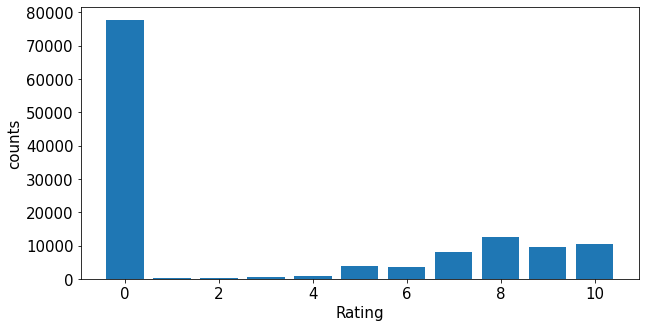

In [39]:
RatingCount = usa_ratings.bookRating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(RatingCount.index, RatingCount.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

There are many users who have 0 ratings.This should be an issue.

Perhaps our model will be better if we'll only include explicit ratings thus 0 rating entries will be removed.

In [40]:
usa_ratings_No0 = usa_ratings[usa_ratings.bookRating != 0]

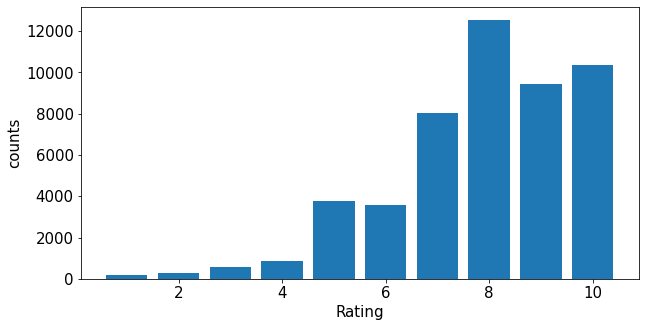

In [41]:
RatingCountNo0 = usa_ratings_No0.bookRating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(RatingCountNo0.index, RatingCountNo0.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

In [42]:
usa_ratings_No0_pivot = usa_ratings_No0.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)

In [43]:
arr2 = usa_ratings_No0_pivot.to_numpy()
arr2.shape[0]

16020

In [44]:
nUsers = arr2.shape[0] 
nItems = arr2.shape[1] 

nRows, nCols= arr2.shape
#r=np.random.rand(nUsers, nItems)

#you can change the number of neighbors, currently it's 1
similarUsers, similarities=findKSimilar (arr2,1)

mae=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr2, similarUsers, similarities)
   #     print ('prediction, real',rhat,r[i,j])
        mae=mae+np.abs(rhat-arr2[i,j])
mae=mae/(nRows*nCols)        
print ('Mean Absolute Error (MAE)=',mae)

Mean Absolute Error (MAE)= 0.019048467861562543


In [45]:
nUsers = arr2.shape[0] 
nItems = arr2.shape[1] 

nRows, nCols= arr2.shape
#r=np.random.rand(nUsers, nItems)

#you can change the number of neighbors, currently it's 1
similarUsers, similarities=findKSimilar (arr2,1)


rmse=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr2, similarUsers, similarities)
   #     print ('prediction, real',rhat,r[i,j])
        rmse=rmse+np.square(rhat-arr2[i,j])
rmse=np.sqrt(rmse/(nRows*nCols))      
print ('Mean Squared Error (RMSE)=',rmse)

Mean Squared Error (RMSE)= 0.377224600050466


# We will set the threshold for books ratings at >7 this time.After trying different values for 'fair' book ratings this was the most optimal one.

In [46]:
tp=fn=fp=fn=0
for i in range(0,nUsers):
    for j in range(0, nItems):
        rhat=predict (i,j,arr2, similarUsers, similarities)
        if rhat>=7 and arr2[i,j]>=7:
            tp=tp+1
        elif rhat>=7 and arr2[i,j]<7:
            fp=fp+1
        elif rhat<7 and arr2[i,j]>=7:
            fn=fn+1
            
            
precision=tp/(tp+fp)
recall = tp/(tp+fn)


print ('Precision=',precision)
print ('Recall=',recall)

Precision= 0.7877083112196157
Recall= 0.36764013772262266


In [47]:
if precision != 0 and recall != 0:
    f1 = 2 * precision * recall / (precision + recall)
    print('F1=', f1)

F1= 0.5013088342087042


In [48]:
print('All Together:')

print ('Mean Absolute Error (MAE)=',mae)
print ('Mean Squared Error (RMSE)=',rmse)
print ('Precision=',precision)
print ('Recall=',recall)
print('F1=', f1)

All Together:
Mean Absolute Error (MAE)= 0.019048467861562543
Mean Squared Error (RMSE)= 0.377224600050466
Precision= 0.7877083112196157
Recall= 0.36764013772262266
F1= 0.5013088342087042


The Recall might be still low but at least from the books retrieved close to 80% are relevant. Definitely a huge improvement. This also shows on MAE and RMSE scores that are lower.

# The results are still not good but better compared to our old dataset and model

We cleaned our data including explicit ratings and tuned the parameters.For the precision and recall we choose to retrieve books with ratings >7 and it works better that way.Adjusting the k neighbors to more than 1 didn't make any significant difference 

# Q2: Recommender System: Improving the recommendation-algorithms: 15%

We will try the SVD and NMF algorithms in this section and see if we can retrieve better results

In [49]:
from surprise import Reader, Dataset

In [50]:
usa_ratings.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location,Age
0,276727,0446520802,0,The Notebook,650,"h, new south wales, australia",16.0
2,638,0446520802,0,The Notebook,650,"san diego, california, usa",20.0
3,3363,0446520802,0,The Notebook,650,"knoxville, tennessee, usa",29.0
4,7158,0446520802,10,The Notebook,650,"omaha, nebraska, usa",30.0
5,8253,0446520802,10,The Notebook,650,"tulsa, oklahoma, usa",26.0


In [51]:
user_item_rating = usa_ratings_No0[['userID', 'ISBN', 'bookRating']]
user_item_rating.head()

,userID,ISBN,bookRating
4,7158,0446520802,10
5,8253,0446520802,10
11,19371,0446520802,4
12,23768,0446520802,6
14,26525,0446520802,10


In [52]:
# First need to create a 'Reader' object to set the scale/limit of the ratings field
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'Dataset' object directly from the pandas df.
# Note: The fields must be in the order: user, item, rating
data = Dataset.load_from_df(user_item_rating, reader)



In [53]:
# Load the models and 'evaluation' method
from surprise import SVD, NMF, model_selection, accuracy

In [54]:
# Load SVD algorithm
model = SVD()

# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6064  1.6311  1.5779  1.5901  1.5797  1.5970  0.0198  
Fit time          0.58    0.60    0.60    0.60    0.60    0.60    0.01    
Test time         0.07    0.06    0.06    0.07    0.14    0.08    0.03    
CPU times: total: 3.95 s
Wall time: 3.97 s


{'test_rmse': array([1.60642011, 1.63107602, 1.57789615, 1.59009538, 1.57965976]),
 'fit_time': (0.5822703838348389,
  0.6041688919067383,
  0.5972130298614502,
  0.5954370498657227,
  0.5967998504638672),
 'test_time': (0.06694531440734863,
  0.06491541862487793,
  0.06493377685546875,
  0.06504940986633301,
  0.14286041259765625)}

The SVD Model gave a worse RMSE of 1.60 compared to our previous algorithm with a result of 0.38



In [55]:
# Load NMF algorithm
model = NMF()
# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5339  2.5514  2.5454  2.5441  2.5307  2.5411  0.0077  
Fit time          1.70    1.70    1.70    1.70    1.71    1.70    0.00    
Test time         0.06    0.06    0.06    0.06    0.06    0.06    0.00    
CPU times: total: 9.34 s
Wall time: 9.4 s


{'test_rmse': array([2.53391677, 2.55135982, 2.54538088, 2.54411718, 2.53067559]),
 'fit_time': (1.7007017135620117,
  1.7028319835662842,
  1.701348066329956,
  1.703744888305664,
  1.706773042678833),
 'test_time': (0.05892658233642578,
  0.05794072151184082,
  0.05694174766540527,
  0.05794119834899902,
  0.05894017219543457)}

The NMF Model gave a way worse RMSE of 2.54 compared to our previous algorithm with a result of 1.59

# Conclusion

To conclude, among the different approaches that were investigated, the best algorithm for RMSE is the first manual one with the K-Neighbors. The Precision/Recall and F1 scores were not as good as we expected at first but after some data cleaning and tuning, the results were way better.The SVD and NMF models weren't better.There is still room for improvement thought and if we had more time, we should make better data cleaning adjustments or choose a different segment of it. 

We faced few difficulties with the memory thus, we were forced to choose a way smaller dataset due to resource limitations in pandas. But in the end, we managed to make our predictions of book titles to users. If we had more time, we could use more specific segmentations and see if the models work better.

Lastly, it’s important to mention that all models took about the same time to run which was considerable fast.  

